In [6]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.
This script can run on CPU in a few minutes.
Results example: http://i.imgur.com/4nj4KjN.jpg
'''
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as PLT
from keras import applications

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imsave', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [65]:
# Question 1 - Part 1
# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('\nModel loaded.')

model.summary()


Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Quesiton 1 - Part 1

There 19 layers. There are 14,714,688 trainable parameters that need to be optimized.

Model loaded.
Processing filter 0


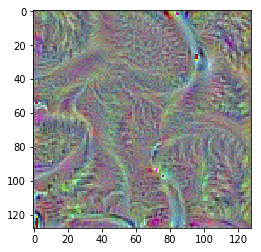

In [66]:
#Question 1 - Part 2

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

# model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


kept_filters = []
for filter_index in range(1):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    #print(input_img_data)
    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        # print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 1

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
PLT.imshow(stitched_filters)
PLT.show()
#imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

Question 1 - Part 2

1st filter of the 3rd convolutional layer of the 5th block of the network.
Gradient ascent for 20 times with learning rate 1.0.

Model loaded.
Processing filter 0


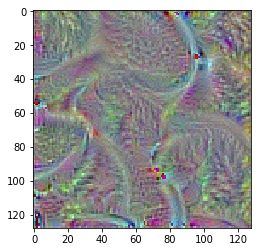

In [67]:
#Question 1 - Part 4

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image

# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

# model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])



kept_filters = []
for filter_index in range(1):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    #if K.image_data_format() == 'channels_first':
    #    input_img_data = np.random.random((1, 3, img_width, img_height))
    #else:
    #    input_img_data = np.random.random((1, img_width, img_height, 3))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    input_img_data = [stitched_filters]
    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        # print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 1

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
PLT.imshow(stitched_filters)
PLT.show()
#imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

Question 1 - Part 4

I choose the image that was produced from Question 1 - Part 2 as my image for the filter to used. 

Model loaded.
block1_conv1


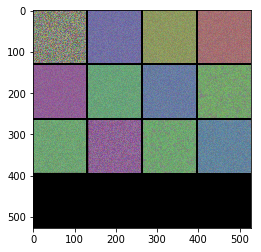



block2_conv1


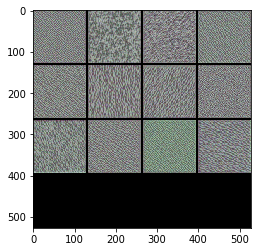



block3_conv1


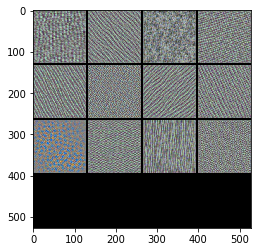



block4_conv1


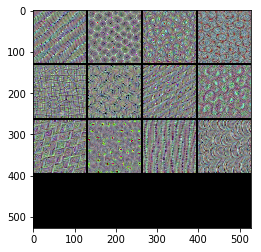



block5_conv1


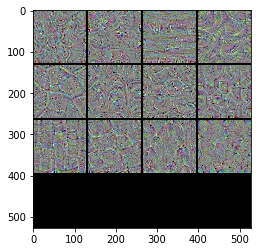

In [68]:
# Question 1 - Part 3

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
# layer_name = 'block5_conv1'

layer_names = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']


# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

# model.summary()


for layer_name in layer_names:
    # this is the placeholder for the input images
    input_img = model.input
    
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    
    
    kept_filters = []
    for filter_index in range(64):
        # we only scan through the first 200 filters,
        # but there are actually 512 of them
        #print('Processing filter %d' % filter_index)
        start_time = time.time()
    
        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])
    
        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]
    
        # normalization trick: we normalize the gradient
        grads = normalize(grads)
    
        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])
    
        # step size for gradient ascent
        step = 1.
    
        # we start from a gray image with some random noise
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 3, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128
    
        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step
    
            # print('Current loss value:', loss_value)
            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break
    
        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
        end_time = time.time()
        #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))
    
    # we will stich the best 16 filters on a 8 x 8 grid.
    n = 4
    
    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:3 * 4]
    
    # build a black picture with enough space for
    # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
    margin = 5
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))
    
    # fill the picture with our saved filters
    for i in range(3):
        for j in range(4):
            img, loss = kept_filters[i * n + j]
            stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                             (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img
    
    # plot the filters
    print(layer_name)
    PLT.imshow(stitched_filters)
    PLT.show()
    print('\n')
    #imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

Question 1 - Part 3

As we go up in layers each of the layers seem to focus on a specific pattern or feature of the image.

block1_conv1 output seems to focus on color of the image.

block2_conv1 and block3_conv1 seems to be linear patterns in the image.

block4_conv1 and block5_conv1 output seem to foucs on different textures of the image such as scales, curves or blobs.

Model loaded.

Processing filter 0
Step Size/Number of Steps/Loss Value:1.0/99/0.999233


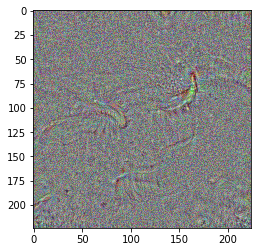

Processing filter 1
Step Size/Number of Steps/Loss Value:1.0/99/0.999076


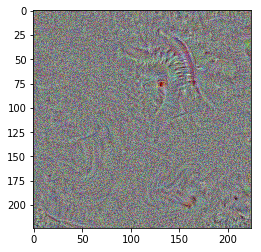

Processing filter 2
Step Size/Number of Steps/Loss Value:1.0/99/0.999423


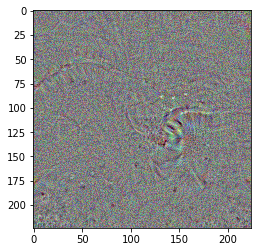

Processing filter 3
Step Size/Number of Steps/Loss Value:1.0/99/0.999375


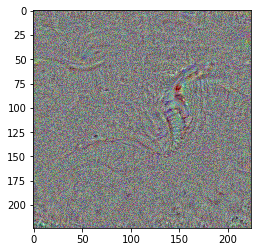

Processing filter 4
Step Size/Number of Steps/Loss Value:1.0/99/0.999295


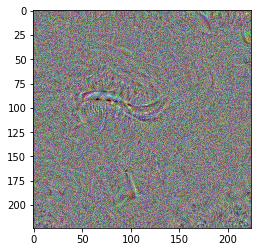

In [4]:
# Question 1 - Part 5
# dimensions of the generated pictures for each filter.
img_width = 224
img_height = 224

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image

# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(include_top=True,
                           weights='imagenet')
print('Model loaded.\n')

output_index = 65
loss = K.mean(model.output[:, output_index])
#model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


kept_filters = []
for filter_index in range(5):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    #layer_output = layer_dict[layer_name].output
    #if K.image_data_format() == 'channels_first':
    #    loss = K.mean(layer_output[:, filter_index, :, :])
    #else:
    #    loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    nSteps = 0
    loss_value = 0
    # we run gradient ascent for 20 steps
    for i in range(100):
        nSteps = i
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break
    
    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))
    print("Step Size/Number of Steps/Loss Value:" + str(step) + '/' + str(nSteps) + '/' + str(loss_value))
    PLT.imshow(img)
    PLT.show()


Question 1 - Part 5

The network is aroudn 99.9% certain that the image is a sea snake. Based on visual observation, the sea snake part is identifiable in the image by the texture and shape of the distortion.

Model loaded.

Processing filter 0
Step Size/Number of Steps/Loss Value:1.0/99/0.998912


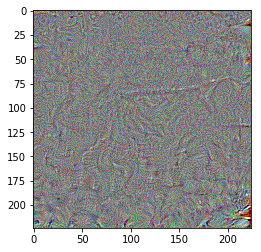

Processing filter 1
Step Size/Number of Steps/Loss Value:1.0/99/0.999039


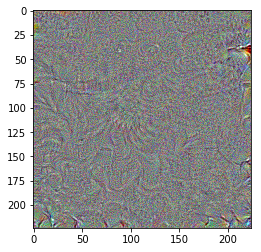

Processing filter 2
Step Size/Number of Steps/Loss Value:1.0/99/0.999238


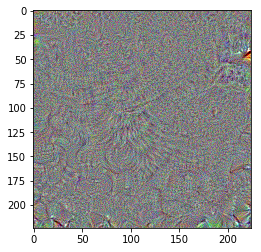

Processing filter 3
Step Size/Number of Steps/Loss Value:1.0/99/0.999244


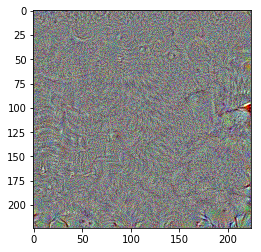

Processing filter 4
Step Size/Number of Steps/Loss Value:1.0/99/0.999212


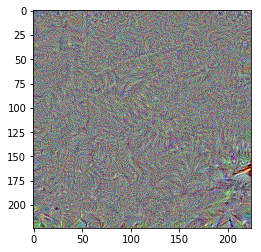

In [5]:
# Question 1 - Part 6

# dimensions of the generated pictures for each filter.
img_width = 224
img_height = 224

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image

# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(include_top=True,
                           weights='imagenet')
print('Model loaded.\n')

output_index = 18
loss = K.mean(model.output[:, output_index])
#model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


kept_filters = []
for filter_index in range(5):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    #layer_output = layer_dict[layer_name].output
    #if K.image_data_format() == 'channels_first':
    #    loss = K.mean(layer_output[:, filter_index, :, :])
    #else:
    #    loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    nSteps = 0
    loss_value = 0
    # we run gradient ascent for 20 steps
    for i in range(100):
        nSteps = i
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break
    
    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))
    print("Step Size/Number of Steps/Loss Value:" + str(step) + '/' + str(nSteps) + '/' + str(loss_value))
    PLT.imshow(img)
    PLT.show()


Question 1 - Part 6

The network is 99.9% certain that the image is a Magpie. Based on visual observation, the magpie part is identifiable in the image by the texture and shape of the distortion.

Problem 2:
1.	Precision @ 1 = 0.608
2.	Precision @ 1 = 0.604
	The effect of the random-flip is to artifically increase training dataset size by adding flipped copies of the images. This increased performance, likely by providing the model the ability to better recognize images regardless of direction.
3. 	Precision @ 1 = 0.612
The  effect of the random-distortion is to artificially increase training dataset size by creating copies of the images with varying contrast and brightness. Performance is higher without this step however, possibly due to the unpredictable nature of the random changes (we don't know how much brightness and contrast change is being done).
4.	Preprocessing decreased performance slightly (highest was 0.612, vs the pre-processed precision of 0.608). Specifically, it seems that the random distorting process decreased precision. It is possible that the addition of imges in strange or unnatural lighting/colors confused the model and made it more difficult to predict correctly the training images in the original set. On the other hand the random flipping improved precision slightly although this was less than the decrease from the distortion. The flipping does not create unnatural images/scenarios so it may be that it successfully diversifies the the model without adding noise.
5.	Other exampels of preprocessing for images includes resizing, cropping, various transformations, various color adjustments, denoising, etc. Given what we learned from our model, a possible strong preprocessing approach could be denoising in order to provide image clarity, flipping in order to increase data set size, and resizing to handle cases when objects are more difficult to discern due to size in the image (too small to recognize, or too large to process).

Problem 3


For our final project, we are aiming to apply machine learning techniques and predictive analytics to forecast the winner of March Madness. In order to achieve this, we plan on collecting data relevant to the history of each of the teams. We will use publicly available features such as number of wins, number of losses, pre-season ranking, offensive efficiency, defensive efficiency, geographic location, head coach salary, number of fouls, etc for that current year and previous years. The previous year’s dataset may provide insight into trends into the team’s scoring. We will also employ feature generation to create our own artificial features such as roster strength (sum of each player’s ranking), roster depth (how many bench players are available for each position), etc. These artificially generated features may lend some extra untapped variance to the model inputs.

Additionally, there are large datasets which provide these features to us. We may be able to extend our predictive model to not only predict the top winners of March Madness but also how far each team is likely to get in the competition. We will need to engineer a label that indicates a specific team’s ranking in March Madness that year. For example, if Duke was eliminated in semifinals in 2005, it would receive the rank 3 or 4 in the label. In this way we can use a regression model to predict a value between 0 and 67 for each team. We do not have to dummy code these output variables because we are assuming the gap between these outcomes is roughly equal in value (i.e. difference between 1st and 2nd place is equal to difference between 2nd and 3rd place, and so on).

Preliminary data analysis will include some sort of feature selection/extraction, as there are a large amount of features that may be extraneous to the prediction. Subsequently, we will try out different regressions and ensembles to build a robust and accurate machine learning model.

Some improvements include predicting a confidence score in each of the rankings. We could also design the overall model in such a way that if one of the early predictions is wrong (eg. a team predicted to win in round of 64 actually loses), we can update the model accordingly in real time and have it adjust the outputs to predict the new ordering.
